Воопрос 2

﻿2. При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции y = x^3 - 6√x + 1 на отрезке [0, 10]. 
Реализуйте процесс поиска экстремума таким образом, чтобы при точки экстремума процедура поиска останавливалась. 
Продемонстрируйте процесс оптимизации. Изобразите график функции у(х) на заданном отрезке. (20 баллов).
нахождении

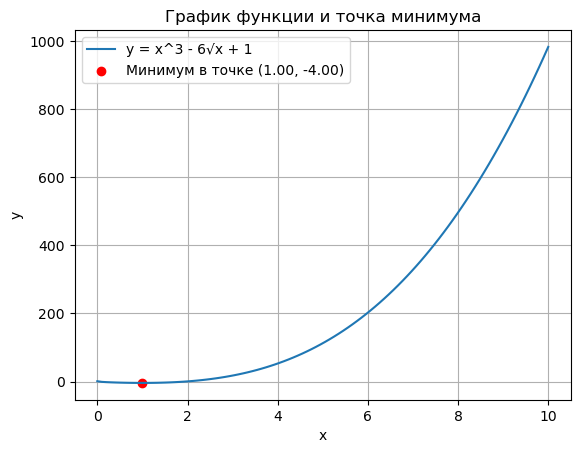

(1.0000011920928955, -4.0)

In [1]:
import torch
import matplotlib.pyplot as plt

def function(x):
    return x**3 - 6*torch.sqrt(x) + 1

x = torch.tensor([10.0], requires_grad=True)

optimizer = torch.optim.SGD([x], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()
    y = function(x)
    y.backward()
    optimizer.step()
    if x.grad.norm() < 1e-5:
        break

minimum = x.item()
minimum_value = function(x).item()


x_graph = torch.linspace(0, 10, 100)
y_graph = function(x_graph).detach()

plt.plot(x_graph, y_graph, label="y = x^3 - 6√x + 1")
plt.scatter(minimum, minimum_value, color='red', label=f"Минимум в точке ({minimum:.2f}, {minimum_value:.2f})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("График функции и точка минимума")
plt.grid(True)
plt.show()

minimum, minimum_value

Vopros 3

3. Реализовав рекуррентную нейронную сеть при помощи библиотеки PyTorch, решите задачу классификации текстов. Разделите набор данных на обучающее и тестовое множество. Проверьте, является ли выборка сбалансированной. При проведении процедуры обучения на несбалансированной выборке задайте параметр weight при создании функции потерь. Отобразите графики значений функции потерь на обучающем множестве. Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.
4. 
• Датасет: activities.csv
Столбец с исходными данными: Text
• Столбец для прогнозирования: Review-Activity. (20 баллов)

[nltk_data] Downloading package punkt to /home/qtr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
Количество экземпляров в обучающей выборке по классам: Counter({'ACTIVITY': 4008, 'REVIEW': 2992})
Количество экземпляров в тестовой выборке по классам: Counter({'ACTIVITY': 1718, 'REVIEW': 1282})
Обучающая выборка сбалансирована: False
Тестовая выборка сбалансирована: False
Epoch 1/20
Train Loss: 0.7195 Acc: 0.4994
Test Loss: 0.6931 Acc: 0.4193
------------------------------------------------------------
Epoch 2/20
Train Loss: 0.6940 Acc: 0.4939
Test Loss: 0.6917 Acc: 0.5857
------------------------------------------------------------
Epoch 3/20
Train Loss: 0.6904 Acc: 0.5246
Test Loss: 0.6927 Acc: 0.5833
------------------------------------------------------------
Epoch 4/20
Train Loss: 0.6891 Acc: 0.5077
Test Loss: 0.6949 Acc: 0.5850
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.6918 Acc: 0.5240
Test Loss: 0.6890 Acc: 0.5843
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.6857 Acc: 0.518

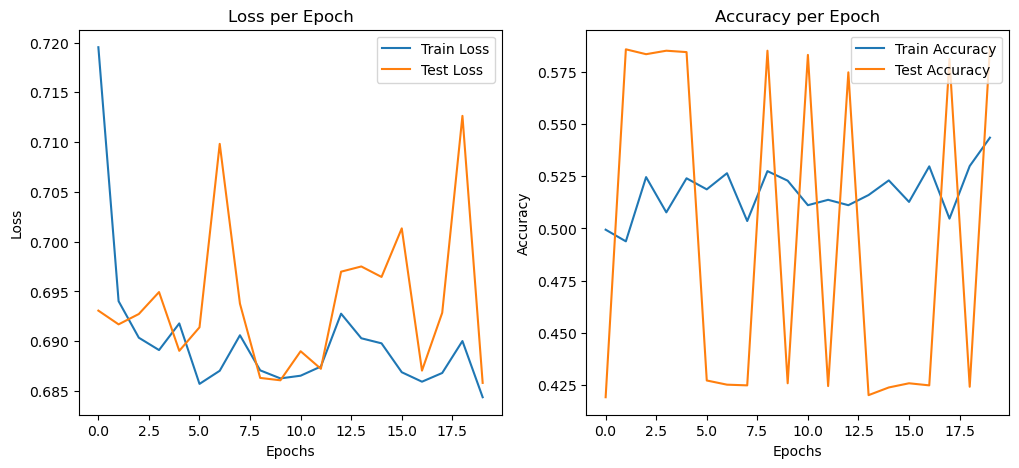

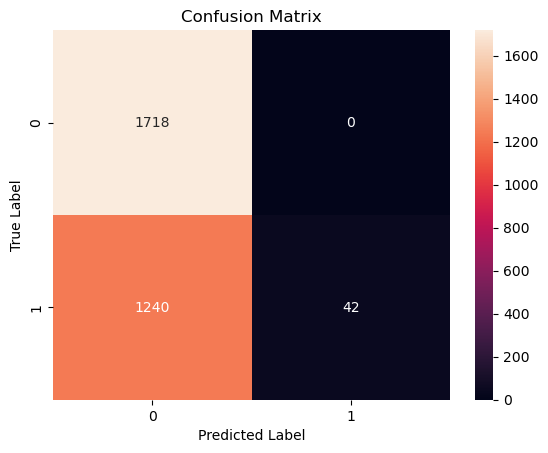

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1718
           1       1.00      0.03      0.06      1282

    accuracy                           0.59      3000
   macro avg       0.79      0.52      0.40      3000
weighted avg       0.76      0.59      0.45      3000



In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
import nltk
import seaborn as sns
nltk.download('punkt')

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data = pd.read_csv('nlp/activities.csv')

X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Review-Activity'], test_size=0.3, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)

print(f"Количество экземпляров в обучающей выборке по классам: {train_class_counts}")
print(f"Количество экземпляров в тестовой выборке по классам: {test_class_counts}")

is_balanced_train = len(set(train_class_counts.values())) == 1
is_balanced_test = len(set(test_class_counts.values())) == 1

print(f"Обучающая выборка сбалансирована: {is_balanced_train}")
print(f"Тестовая выборка сбалансирована: {is_balanced_test}")

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

word_counts = Counter(word for text in X_train for word in word_tokenize(text.lower()))
vocab = {word: i + 1 for i, (word, count) in enumerate(word_counts.items())}

def text_to_sequence(text, vocab):
    return [vocab.get(word, 0) for word in word_tokenize(text.lower())]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = list(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_sequence = text_to_sequence(self.texts[idx], vocab)
        return torch.tensor(text_sequence, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return sequences_padded, labels

train_dataset = TextDataset(X_train, y_train_encoded)
test_dataset = TextDataset(X_test, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=96, shuffle=False, collate_fn=collate_fn)

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embedding_dim = 200
hidden_size = 256
num_classes = len(np.unique(y_train_encoded))

model = RNN(vocab_size, embedding_dim, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for sequences_padded, labels in train_loader:
        sequences_padded, labels = sequences_padded.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences_padded)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for sequences_padded, labels in test_loader:
            sequences_padded, labels = sequences_padded.to(device), labels.to(device)
            outputs = model(sequences_padded)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f}')
    print(f'Test Loss: {test_losses[-1]:.4f} Acc: {test_accuracies[-1]:.4f}')
    print('-' * 60)

# Визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Оценка модели и вывод матрицы ошибок
y_pred = []
y_true = []
with torch.no_grad():
    for sequences_padded, labels in test_loader:
        sequences_padded, labels = sequences_padded.to(device), labels.to(device)
        outputs = model(sequences_padded)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred))